In [1]:
NOTE = 'CatBoost-Ordered特徴量ミニマム'
notebook_name = '061'

In [2]:
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [3]:
N = 5
CV = f'Stratified-Kfold(K={N})'

OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

# class_weights for CatBoostClassifier, copied from 020
CLASS_WEIGHTS = {
        0: 0.33822833,
        1: 0.4574968, 
        2: 0.71590909,
        3: 1.00280899,
        4: 3.17333333,
        5: 11.45454545,
        6: 194.72727273,
        7: 17.85
    }

061_submission.csv 061


In [4]:
def get_estimator(*,
                  categorical_features=None,
                  discrete_features=None,
                  vector_features=None,
                  features=None) -> Pipeline:

    clf = CatBoostClassifier(random_state=SEED,
                             train_dir=OUTPUT_DIR,
                             class_weights=CLASS_WEIGHTS,
                             boosting_type='Ordered',
                             n_estimators=300,
                             learning_rate=0.01)
    return Pipeline(
        steps=[
            ('estimator', clf)
         ]
    )

In [5]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [6]:
CATEGORICAL_FEATURES

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [7]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
discrete_features = list(set(minimal_features) - set(categorical_features))
print(categorical_features)
print(discrete_features)

# Execute if categories should be one-hot style
# for c in categorical_features:
#     assert(train[c].isin(test[c]).sum() == train.shape[0])
#     assert(test[c].isin(train[c]).sum() == test.shape[0])

# train = pd.get_dummies(train, columns=categorical_features, drop_first=True)
# test = pd.get_dummies(test, columns=categorical_features, drop_first=True)

# assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
# assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

# categorical_features_1hot = []
# for c in categorical_features:
#     categorical_features_1hot += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
# print(categorical_features_1hot)

# features = discrete_features + categorical_features_1hot
features = discrete_features + categorical_features

['b1', 'b2', 'b3', 'batterID', 'pitcherID', 'Match', 'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher', 'isBottom', 'batterTeam', 'pitcherTeam']
['totalPitchingCount', 'inningNo', 'numRunners', 'S', 'B', 'O']


In [8]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [9]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [10]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )

    clf = get_estimator(features=features,
                        discrete_features=discrete_features,
                        categorical_features=categorical_features)
#     class_weight = compute_class_weight('balanced',
#                                         classes=np.sort(train.y.unique()),
#                                         y=y_train.values)
#     class_weight = dict(
#         zip(
#             np.sort(train.y.unique()),
#             class_weight
#         )
#     )
#     sample_weight = y_train.map(class_weight)
#     assert(sample_weight.isnull().sum() == 0)
    sample_weight = None
    clf.fit(X_train,
            y_train.values,
            estimator__sample_weight=sample_weight)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



0:	learn: 2.0764196	total: 482ms	remaining: 2m 23s
1:	learn: 2.0724224	total: 733ms	remaining: 1m 49s
2:	learn: 2.0709178	total: 939ms	remaining: 1m 32s
3:	learn: 2.0685864	total: 1.24s	remaining: 1m 31s
4:	learn: 2.0644269	total: 1.63s	remaining: 1m 36s
5:	learn: 2.0620303	total: 1.97s	remaining: 1m 36s
6:	learn: 2.0603106	total: 2.27s	remaining: 1m 34s
7:	learn: 2.0580703	total: 2.56s	remaining: 1m 33s
8:	learn: 2.0567387	total: 2.83s	remaining: 1m 31s
9:	learn: 2.0546889	total: 3.06s	remaining: 1m 28s
10:	learn: 2.0525639	total: 3.4s	remaining: 1m 29s
11:	learn: 2.0511242	total: 3.69s	remaining: 1m 28s
12:	learn: 2.0494801	total: 3.88s	remaining: 1m 25s
13:	learn: 2.0476445	total: 4.19s	remaining: 1m 25s
14:	learn: 2.0442215	total: 4.44s	remaining: 1m 24s
15:	learn: 2.0419121	total: 4.6s	remaining: 1m 21s
16:	learn: 2.0383638	total: 4.91s	remaining: 1m 21s
17:	learn: 2.0362060	total: 5.14s	remaining: 1m 20s
18:	learn: 2.0339997	total: 5.36s	remaining: 1m 19s
19:	learn: 2.0319260	tot

162:	learn: 1.8000865	total: 38s	remaining: 31.9s
163:	learn: 1.7991415	total: 38.3s	remaining: 31.7s
164:	learn: 1.7977101	total: 38.5s	remaining: 31.5s
165:	learn: 1.7973126	total: 38.6s	remaining: 31.2s
166:	learn: 1.7969144	total: 38.8s	remaining: 30.9s
167:	learn: 1.7967963	total: 38.9s	remaining: 30.6s
168:	learn: 1.7950576	total: 39.1s	remaining: 30.3s
169:	learn: 1.7942300	total: 39.3s	remaining: 30.1s
170:	learn: 1.7931222	total: 39.5s	remaining: 29.8s
171:	learn: 1.7924944	total: 39.7s	remaining: 29.6s
172:	learn: 1.7916180	total: 40s	remaining: 29.4s
173:	learn: 1.7905809	total: 40.3s	remaining: 29.2s
174:	learn: 1.7891408	total: 40.5s	remaining: 28.9s
175:	learn: 1.7881206	total: 40.7s	remaining: 28.7s
176:	learn: 1.7879302	total: 40.8s	remaining: 28.4s
177:	learn: 1.7866792	total: 41s	remaining: 28.1s
178:	learn: 1.7853018	total: 41.3s	remaining: 27.9s
179:	learn: 1.7843380	total: 41.5s	remaining: 27.7s
180:	learn: 1.7830403	total: 41.7s	remaining: 27.4s
181:	learn: 1.7817

7:	learn: 2.0498118	total: 2.07s	remaining: 1m 15s
8:	learn: 2.0463923	total: 2.35s	remaining: 1m 15s
9:	learn: 2.0425886	total: 2.62s	remaining: 1m 15s
10:	learn: 2.0390532	total: 2.95s	remaining: 1m 17s
11:	learn: 2.0353022	total: 3.2s	remaining: 1m 16s
12:	learn: 2.0323753	total: 3.5s	remaining: 1m 17s
13:	learn: 2.0290431	total: 3.79s	remaining: 1m 17s
14:	learn: 2.0257572	total: 4s	remaining: 1m 16s
15:	learn: 2.0231507	total: 4.3s	remaining: 1m 16s
16:	learn: 2.0201490	total: 4.54s	remaining: 1m 15s
17:	learn: 2.0182169	total: 4.83s	remaining: 1m 15s
18:	learn: 2.0158785	total: 5.04s	remaining: 1m 14s
19:	learn: 2.0135224	total: 5.29s	remaining: 1m 14s
20:	learn: 2.0118526	total: 5.54s	remaining: 1m 13s
21:	learn: 2.0103721	total: 5.77s	remaining: 1m 12s
22:	learn: 2.0076162	total: 5.98s	remaining: 1m 11s
23:	learn: 2.0062015	total: 6.19s	remaining: 1m 11s
24:	learn: 2.0026201	total: 6.52s	remaining: 1m 11s
25:	learn: 1.9990628	total: 6.75s	remaining: 1m 11s
26:	learn: 1.9955677	

168:	learn: 1.7841558	total: 40.7s	remaining: 31.5s
169:	learn: 1.7829760	total: 41s	remaining: 31.3s
170:	learn: 1.7821830	total: 41.2s	remaining: 31.1s
171:	learn: 1.7806315	total: 41.4s	remaining: 30.8s
172:	learn: 1.7795438	total: 41.7s	remaining: 30.6s
173:	learn: 1.7786013	total: 41.9s	remaining: 30.4s
174:	learn: 1.7767751	total: 42.1s	remaining: 30.1s
175:	learn: 1.7755306	total: 42.5s	remaining: 29.9s
176:	learn: 1.7745005	total: 42.7s	remaining: 29.6s
177:	learn: 1.7730868	total: 42.9s	remaining: 29.4s
178:	learn: 1.7716852	total: 43.1s	remaining: 29.1s
179:	learn: 1.7708036	total: 43.3s	remaining: 28.9s
180:	learn: 1.7699558	total: 43.4s	remaining: 28.6s
181:	learn: 1.7687213	total: 43.7s	remaining: 28.3s
182:	learn: 1.7674645	total: 43.9s	remaining: 28.1s
183:	learn: 1.7665041	total: 44.2s	remaining: 27.8s
184:	learn: 1.7654934	total: 44.5s	remaining: 27.7s
185:	learn: 1.7640547	total: 44.7s	remaining: 27.4s
186:	learn: 1.7630229	total: 44.9s	remaining: 27.1s
187:	learn: 1.

13:	learn: 2.0338482	total: 3.15s	remaining: 1m 4s
14:	learn: 2.0323998	total: 3.4s	remaining: 1m 4s
15:	learn: 2.0298041	total: 3.62s	remaining: 1m 4s
16:	learn: 2.0276862	total: 3.81s	remaining: 1m 3s
17:	learn: 2.0260728	total: 4.03s	remaining: 1m 3s
18:	learn: 2.0248804	total: 4.2s	remaining: 1m 2s
19:	learn: 2.0228129	total: 4.44s	remaining: 1m 2s
20:	learn: 2.0204312	total: 4.72s	remaining: 1m 2s
21:	learn: 2.0169095	total: 5s	remaining: 1m 3s
22:	learn: 2.0145703	total: 5.36s	remaining: 1m 4s
23:	learn: 2.0121646	total: 5.66s	remaining: 1m 5s
24:	learn: 2.0087606	total: 6.05s	remaining: 1m 6s
25:	learn: 2.0060206	total: 6.54s	remaining: 1m 8s
26:	learn: 2.0023802	total: 6.89s	remaining: 1m 9s
27:	learn: 2.0003642	total: 7.23s	remaining: 1m 10s
28:	learn: 1.9973241	total: 7.45s	remaining: 1m 9s
29:	learn: 1.9951328	total: 7.66s	remaining: 1m 8s
30:	learn: 1.9916480	total: 8.12s	remaining: 1m 10s
31:	learn: 1.9890621	total: 8.39s	remaining: 1m 10s
32:	learn: 1.9860322	total: 8.59s

174:	learn: 1.7753205	total: 43.6s	remaining: 31.2s
175:	learn: 1.7747139	total: 43.8s	remaining: 30.9s
176:	learn: 1.7727188	total: 44.1s	remaining: 30.6s
177:	learn: 1.7717077	total: 44.3s	remaining: 30.3s
178:	learn: 1.7712581	total: 44.5s	remaining: 30.1s
179:	learn: 1.7699721	total: 44.8s	remaining: 29.8s
180:	learn: 1.7697645	total: 44.9s	remaining: 29.5s
181:	learn: 1.7684709	total: 45s	remaining: 29.2s
182:	learn: 1.7672999	total: 45.3s	remaining: 29s
183:	learn: 1.7662361	total: 45.5s	remaining: 28.7s
184:	learn: 1.7649589	total: 45.7s	remaining: 28.4s
185:	learn: 1.7634741	total: 46s	remaining: 28.2s
186:	learn: 1.7618526	total: 46.2s	remaining: 27.9s
187:	learn: 1.7598422	total: 46.5s	remaining: 27.7s
188:	learn: 1.7592425	total: 46.6s	remaining: 27.4s
189:	learn: 1.7585325	total: 46.7s	remaining: 27.1s
190:	learn: 1.7576913	total: 46.9s	remaining: 26.8s
191:	learn: 1.7573380	total: 47s	remaining: 26.4s
192:	learn: 1.7557061	total: 47.4s	remaining: 26.3s
193:	learn: 1.754840

19:	learn: 2.0171891	total: 4.28s	remaining: 59.9s
20:	learn: 2.0153159	total: 4.47s	remaining: 59.3s
21:	learn: 2.0120008	total: 4.76s	remaining: 1m
22:	learn: 2.0094081	total: 5s	remaining: 1m
23:	learn: 2.0057915	total: 5.26s	remaining: 1m
24:	learn: 2.0049385	total: 5.37s	remaining: 59s
25:	learn: 2.0021026	total: 5.69s	remaining: 59.9s
26:	learn: 1.9984829	total: 5.91s	remaining: 59.8s
27:	learn: 1.9953552	total: 6.24s	remaining: 1m
28:	learn: 1.9924567	total: 6.44s	remaining: 1m
29:	learn: 1.9903780	total: 6.66s	remaining: 59.9s
30:	learn: 1.9875784	total: 6.92s	remaining: 1m
31:	learn: 1.9847296	total: 7.12s	remaining: 59.7s
32:	learn: 1.9821800	total: 7.31s	remaining: 59.1s
33:	learn: 1.9778469	total: 7.56s	remaining: 59.2s
34:	learn: 1.9754990	total: 7.91s	remaining: 59.9s
35:	learn: 1.9722227	total: 8.12s	remaining: 59.5s
36:	learn: 1.9697650	total: 8.47s	remaining: 1m
37:	learn: 1.9674625	total: 8.7s	remaining: 1m
38:	learn: 1.9658964	total: 8.87s	remaining: 59.4s
39:	learn:

181:	learn: 1.7511449	total: 40.4s	remaining: 26.2s
182:	learn: 1.7497720	total: 40.4s	remaining: 25.9s
183:	learn: 1.7487137	total: 40.5s	remaining: 25.6s
184:	learn: 1.7480487	total: 40.6s	remaining: 25.3s
185:	learn: 1.7475674	total: 40.7s	remaining: 24.9s
186:	learn: 1.7461124	total: 40.9s	remaining: 24.7s
187:	learn: 1.7454509	total: 41.1s	remaining: 24.5s
188:	learn: 1.7445093	total: 41.3s	remaining: 24.3s
189:	learn: 1.7434279	total: 41.6s	remaining: 24.1s
190:	learn: 1.7422463	total: 41.8s	remaining: 23.9s
191:	learn: 1.7413495	total: 42.1s	remaining: 23.7s
192:	learn: 1.7410951	total: 42.3s	remaining: 23.4s
193:	learn: 1.7396151	total: 42.4s	remaining: 23.2s
194:	learn: 1.7392769	total: 42.6s	remaining: 22.9s
195:	learn: 1.7385575	total: 42.9s	remaining: 22.8s
196:	learn: 1.7372494	total: 43.2s	remaining: 22.6s
197:	learn: 1.7362316	total: 43.4s	remaining: 22.4s
198:	learn: 1.7358116	total: 43.6s	remaining: 22.1s
199:	learn: 1.7346495	total: 43.8s	remaining: 21.9s
200:	learn: 

27:	learn: 1.9840073	total: 6.93s	remaining: 1m 7s
28:	learn: 1.9831005	total: 7.04s	remaining: 1m 5s
29:	learn: 1.9820451	total: 7.25s	remaining: 1m 5s
30:	learn: 1.9801426	total: 7.42s	remaining: 1m 4s
31:	learn: 1.9770283	total: 7.72s	remaining: 1m 4s
32:	learn: 1.9749560	total: 8s	remaining: 1m 4s
33:	learn: 1.9728175	total: 8.23s	remaining: 1m 4s
34:	learn: 1.9717021	total: 8.39s	remaining: 1m 3s
35:	learn: 1.9703232	total: 8.67s	remaining: 1m 3s
36:	learn: 1.9671466	total: 8.82s	remaining: 1m 2s
37:	learn: 1.9653490	total: 8.99s	remaining: 1m 1s
38:	learn: 1.9632562	total: 9.23s	remaining: 1m 1s
39:	learn: 1.9608411	total: 9.43s	remaining: 1m 1s
40:	learn: 1.9585342	total: 9.7s	remaining: 1m 1s
41:	learn: 1.9552735	total: 9.93s	remaining: 1m 1s
42:	learn: 1.9535994	total: 10.2s	remaining: 1m
43:	learn: 1.9524927	total: 10.3s	remaining: 59.9s
44:	learn: 1.9496627	total: 10.6s	remaining: 59.8s
45:	learn: 1.9470028	total: 10.8s	remaining: 59.5s
46:	learn: 1.9452659	total: 11s	remain

188:	learn: 1.7449898	total: 41.1s	remaining: 24.1s
189:	learn: 1.7440140	total: 41.4s	remaining: 24s
190:	learn: 1.7430868	total: 41.6s	remaining: 23.7s
191:	learn: 1.7424932	total: 41.8s	remaining: 23.5s
192:	learn: 1.7413123	total: 42s	remaining: 23.3s
193:	learn: 1.7401192	total: 42.2s	remaining: 23.1s
194:	learn: 1.7394035	total: 42.5s	remaining: 22.9s
195:	learn: 1.7376997	total: 42.7s	remaining: 22.6s
196:	learn: 1.7371938	total: 42.9s	remaining: 22.4s
197:	learn: 1.7365657	total: 43.1s	remaining: 22.2s
198:	learn: 1.7363591	total: 43.2s	remaining: 21.9s
199:	learn: 1.7360531	total: 43.4s	remaining: 21.7s
200:	learn: 1.7347566	total: 43.6s	remaining: 21.5s
201:	learn: 1.7337842	total: 43.9s	remaining: 21.3s
202:	learn: 1.7328490	total: 44s	remaining: 21s
203:	learn: 1.7325802	total: 44.1s	remaining: 20.8s
204:	learn: 1.7311694	total: 44.4s	remaining: 20.6s
205:	learn: 1.7310747	total: 44.6s	remaining: 20.3s
206:	learn: 1.7297965	total: 44.8s	remaining: 20.1s
207:	learn: 1.729113

In [11]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.181076,0.133483
std,0.007165,0.003845
min,0.169581,0.129618
25%,0.178879,0.131176
50%,0.183885,0.131604
75%,0.185715,0.136292
max,0.187319,0.138723


In [12]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,1,0,1
1,1,1,7,0,1
2,2,0,7,0,1
3,3,2,7,0,1
4,4,4,5,0,1
...,...,...,...,...,...
17126,9690,0,1,0,5
17129,9693,1,2,0,5
17130,16833,1,1,0,5
17133,9762,1,0,0,5


In [13]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.097124,0.102515,0.124159,0.128457,0.132749,0.124085,0.172479,0.118433,27446,1
1,0.121118,0.110889,0.128120,0.129490,0.141291,0.104330,0.137853,0.126909,113,1
2,0.164219,0.205786,0.103641,0.086633,0.084178,0.063851,0.162331,0.129361,4479,1
3,0.186781,0.218828,0.114117,0.141757,0.096405,0.086881,0.029635,0.125596,29080,1
4,0.157030,0.136448,0.136468,0.144701,0.135675,0.099288,0.089713,0.100677,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.155312,0.203157,0.116670,0.120349,0.139260,0.084944,0.052015,0.128294,24272,5
33804,0.103647,0.098514,0.167730,0.165276,0.160444,0.125588,0.074029,0.104772,29106,5
33805,0.099615,0.087390,0.180883,0.163719,0.140846,0.165820,0.029915,0.131811,20679,5
33806,0.164536,0.121202,0.151179,0.139826,0.160994,0.106188,0.081198,0.074879,25901,5


In [14]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,0.631682,0.824227,0.610505,0.629279,0.621804,0.607184,0.213687,0.861632
1,1,0.963336,1.256975,0.624289,0.599778,0.470068,0.518412,0.118201,0.448941
2,2,0.388374,0.359199,0.768888,0.743279,0.777707,0.589500,0.749688,0.623364
3,3,0.956681,1.105669,0.570552,0.559224,0.511359,0.466379,0.165672,0.664465
4,4,0.916706,1.075741,0.558654,0.539832,0.506203,0.619555,0.191960,0.591348
...,...,...,...,...,...,...,...,...,...
33803,33803,0.802414,0.707242,0.756904,0.702084,0.688043,0.586259,0.272967,0.484087
33804,33804,0.920029,1.179303,0.613969,0.662261,0.578988,0.361157,0.113469,0.570826
33805,33805,0.922770,1.073722,0.638109,0.767758,0.508832,0.409625,0.110362,0.568822
33806,33806,0.524792,0.615731,0.622291,0.667036,0.695744,0.778282,0.491847,0.604277


In [15]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,7
1,1,1
2,2,4
3,3,1
4,4,1
...,...,...
33803,33803,0
33804,33804,1
33805,33805,1
33806,33806,5


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.130886
1    0.420847
2    0.057590
3    0.072054
4    0.121303
5    0.066789
6    0.045374
7    0.085157
Name: y, dtype: float64

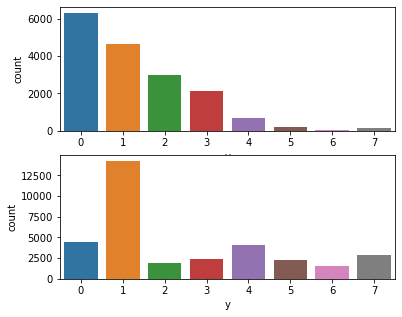

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [17]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [18]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.18107590008350477, 0.13348252242003666)

In [19]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"061_submission.csv","Stratified-Kfold(K=5)","0.181076","0.133483","","CatBoost-Ordered特徴量ミニマム"


In [20]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 87 ms


In [21]:
%%time
imp_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 38 ms


In [22]:
imp_df

,feature,importance,fold
0,totalPitchingCount,4.028059,1
1,inningNo,10.665189,1
2,numRunners,6.635692,1
3,S,12.479088,1
4,B,11.004250,1
...,...,...,...
13,isPitcherHandLeft,0.748722,5
14,isBatterPitcher,0.254743,5
15,isBottom,1.427379,5
16,batterTeam,4.211803,5


In [23]:
%%time
coef_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=features)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 1 ms


In [24]:
coef_df

""
